# Customer Segmentation

In [86]:
import numpy as np
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime as dt
print("Setup Complete")

Setup Complete


In [87]:
df = pd.read_csv('data/marketing_campaign.csv', sep='\t')

In [88]:
df.head()

ID  Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
0  5524        1957  Graduation         Single  58138.0        0         0   
1  2174        1954  Graduation         Single  46344.0        1         1   
2  4141        1965  Graduation       Together  71613.0        0         0   
3  6182        1984  Graduation       Together  26646.0        1         0   
4  5324        1981         PhD        Married  58293.0        1         0   

  Dt_Customer  Recency  MntWines  ...  NumWebVisitsMonth  AcceptedCmp3  \
0  04-09-2012       58       635  ...                  7             0   
1  08-03-2014       38        11  ...                  5             0   
2  21-08-2013       26       426  ...                  4             0   
3  10-02-2014       26        11  ...                  6             0   
4  19-01-2014       94       173  ...                  5             0   

   AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain  \
0             0             0             0             0         0   
1             0             0             0             0         0   
2             0             0             0             0         0   
3             0             0             0             0         0   
4             0             0             0             0         0   

   Z_CostContact  Z_Revenue  Response  
0              3         11         1  
1              3         11         0  
2              3         11         0  
3              3         11         0  
4              3         11         0  

[5 rows x 29 columns]

## Data Cleaning


__Attributes__:

People
- `ID`: Customer's unique identifier
- `Year_Birth`: Customer's birth year
- `Education`: Customer's education level
- `Marital_Status`: Customer's marital status
- `Income`: Customer's yearly household income
- `Kidhome`: Number of children in customer's household
- `Teenhome`: Number of teenagers in customer's household
- `Dt_Customer`: Date of customer's enrollment with the company
- `Recency`: Number of days since customer's last purchase
- `Complain`: 1 if the customer complained in the last 2 years, 0 otherwise

Products

- `MntWines`: Amount spent on wine in last 2 years
- `MntFruits`: Amount spent on fruits in last 2 years
- `MntMeatProducts`: Amount spent on meat in last 2 years
- `MntFishProducts`: Amount spent on fish in last 2 years
- `MntSweetProducts`: Amount spent on sweets in last 2 years
- `MntGoldProds`: Amount spent on gold in last 2 years

Promotion

- `NumDealsPurchases`: Number of purchases made with a discount
- `AcceptedCmp1`: 1 if customer accepted the offer in the 1st campaign, 0 otherwise
- `AcceptedCmp2`: 1 if customer accepted the offer in the 2nd campaign, 0 otherwise
- `AcceptedCmp3`: 1 if customer accepted the offer in the 3rd campaign, 0 otherwise
- `AcceptedCmp4`: 1 if customer accepted the offer in the 4th campaign, 0 otherwise
- `AcceptedCmp5`: 1 if customer accepted the offer in the 5th campaign, 0 otherwise
- `Response`: 1 if customer accepted the offer in the last campaign, 0 otherwise

Place

- `NumWebPurchases`: Number of purchases made through the company’s website
- `NumCatalogPurchases`: Number of purchases made using a catalogue
- `NumStorePurchases`: Number of purchases made directly in stores
- `NumWebVisitsMonth`: Number of visits to company’s website in the last month


In [89]:
print('Number of missing entries:', pd.isnull(df).sum().sum())
# Drop rows with missing entries
df = df.dropna()

Number of missing entries: 24


It appears as if `Z_CostContact` and `Z_Revenue` all have values equal to zero, so we will drop these columns

In [90]:
df = df.drop(['Z_CostContact', 'Z_Revenue'], axis=1)

### Categorical Data

In [91]:
print('Categorical/String Columns:')
df.dtypes[df.dtypes == 'object']

Categorical/String Columns:


Education         object
Marital_Status    object
Dt_Customer       object
dtype: object

In [92]:
df['Marital_Status'].value_counts()

Married     857
Together    573
Single      471
Divorced    232
Widow        76
Alone         3
Absurd        2
YOLO          2
Name: Marital_Status, dtype: int64

In [93]:
df['Marital_Status'] = df['Marital_Status'].replace('Alone', 'Single')
# drop absurd and yolo
df = df.drop(df.index[df['Marital_Status'] == 'Absurd'], axis=0)
df = df.drop(df.index[df['Marital_Status'] == 'YOLO'], axis=0)

It is unclear what absurd and YOLO mean, so we can drop them

Now we shall investigate education level

In [94]:
df['Education'].value_counts()

Graduation    1115
PhD            479
Master         364
2n Cycle       200
Basic           54
Name: Education, dtype: int64

### Numerical Data

What is the range of dates the customers registered?

In [95]:
df['Dt_Customer'] = df['Dt_Customer'].astype('datetime64')
print('Latest dt registered:', df['Dt_Customer'].max())
print('Earliest dt registered:', df['Dt_Customer'].min())

Latest dt registered: 2014-12-06 00:00:00
Earliest dt registered: 2012-01-08 00:00:00


C:\Users\Claudeon\AppData\Local\Temp\ipykernel_108684\325786078.py:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df['Dt_Customer'] = df['Dt_Customer'].astype('datetime64')


In [96]:
latest_reg = df['Dt_Customer'].max()
print('Latest year:', latest_reg.year)

Latest year: 2014


In [97]:
df['Days_Registered'] = pd.to_numeric(latest_reg-df['Dt_Customer'])
df = df.drop('Dt_Customer', axis=1)

We also need to convert customer birth year to current age at the time of recording

In [98]:
df['Age'] = -(df['Year_Birth']) + latest_reg.year
df = df.drop('Year_Birth', axis=1)

To get a bigger picture of the number of children

In [99]:
df['Children'] = df['Kidhome'] + df['Teenhome']
df['Children'].value_counts()

1    1115
0     631
2     416
3      50
Name: Children, dtype: int64

Is the customer is living alone or not?

In [100]:
def is_alone(status):
    if status in ('Married', 'Together'):
        return 0;
    else:
        return 1;
df['Is_Alone'] = df['Marital_Status'].apply(is_alone)
df = df.drop('Marital_Status', axis=1)

Education Status

In [101]:
df["Education"]=df["Education"].replace({
    "Basic":"Undergraduate",
    "2n Cycle":"Undergraduate", 
    "Graduation":"Graduate", 
    "Master":"Postgraduate", 
    "PhD":"Postgraduate"
    })

In [102]:
df = df.drop('ID', axis=1)

In [103]:
df

Education   Income  Kidhome  Teenhome  Recency  MntWines  MntFruits  \
0         Graduate  58138.0        0         0       58       635         88   
1         Graduate  46344.0        1         1       38        11          1   
2         Graduate  71613.0        0         0       26       426         49   
3         Graduate  26646.0        1         0       26        11          4   
4     Postgraduate  58293.0        1         0       94       173         43   
...            ...      ...      ...       ...      ...       ...        ...   
2235      Graduate  61223.0        0         1       46       709         43   
2236  Postgraduate  64014.0        2         1       56       406          0   
2237      Graduate  56981.0        0         0       91       908         48   
2238  Postgraduate  69245.0        0         1        8       428         30   
2239  Postgraduate  52869.0        1         1       40        84          3   

      MntMeatProducts  MntFishProducts  MntSweetProducts  ...  AcceptedCmp4  \
0                 546              172                88  ...             0   
1                   6                2                 1  ...             0   
2                 127              111                21  ...             0   
3                  20               10                 3  ...             0   
4                 118               46                27  ...             0   
...               ...              ...               ...  ...           ...   
2235              182               42               118  ...             0   
2236               30                0                 0  ...             0   
2237              217               32                12  ...             1   
2238              214               80                30  ...             0   
2239               61                2                 1  ...             0   

      AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain  Response  \
0                0             0             0         0         1   
1                0             0             0         0         0   
2                0             0             0         0         0   
3                0             0             0         0         0   
4                0             0             0         0         0   
...            ...           ...           ...       ...       ...   
2235             0             0             0         0         0   
2236             0             1             0         0         0   
2237             0             0             0         0         0   
2238             0             0             0         0         0   
2239             0             0             0         0         1   

        Days_Registered  Age  Children  Is_Alone  
0     83894400000000000   57         0         1  
1     10800000000000000   60         2         1  
2     40780800000000000   49         0         0  
3      5616000000000000   30         1         0  
4     27734400000000000   33         1         0  
...                 ...  ...       ...       ...  
2235  46742400000000000   47         1         0  
2236   5270400000000000   68         3         0  
2237  27216000000000000   33         0         1  
2238  27302400000000000   58         1         0  
2239  67564800000000000   60         2         0  

[2212 rows x 27 columns]

### Feature Engineering (Marketing)
In this section we will be adding some features, most notably:

* `MntTotal`: total amount spent
* `NumTotalPurchases`: total number of purchases made
* `PctDealsPurchases`: percentage of purchases made with discount
* `MntAvg`: Average amount spent per purchase

In [104]:
# Total Amount spent
df['MntTotal'] = df['MntWines'] + df['MntFruits'] + df['MntMeatProducts'] + df['MntFishProducts'] + df['MntSweetProducts'] + df['MntGoldProds']

# Total number of purchases
df['NumTotalPurchases'] = df['NumWebPurchases'] + df['NumCatalogPurchases'] + df['NumStorePurchases']

# Percentage of purchases made with discount
df['PctDealsPurchases'] = df['NumDealsPurchases']/df['NumTotalPurchases']

#Average amount spent per purchase
df['MntAvg'] = df['MntTotal']/df['NumTotalPurchases']

## Data Visualization

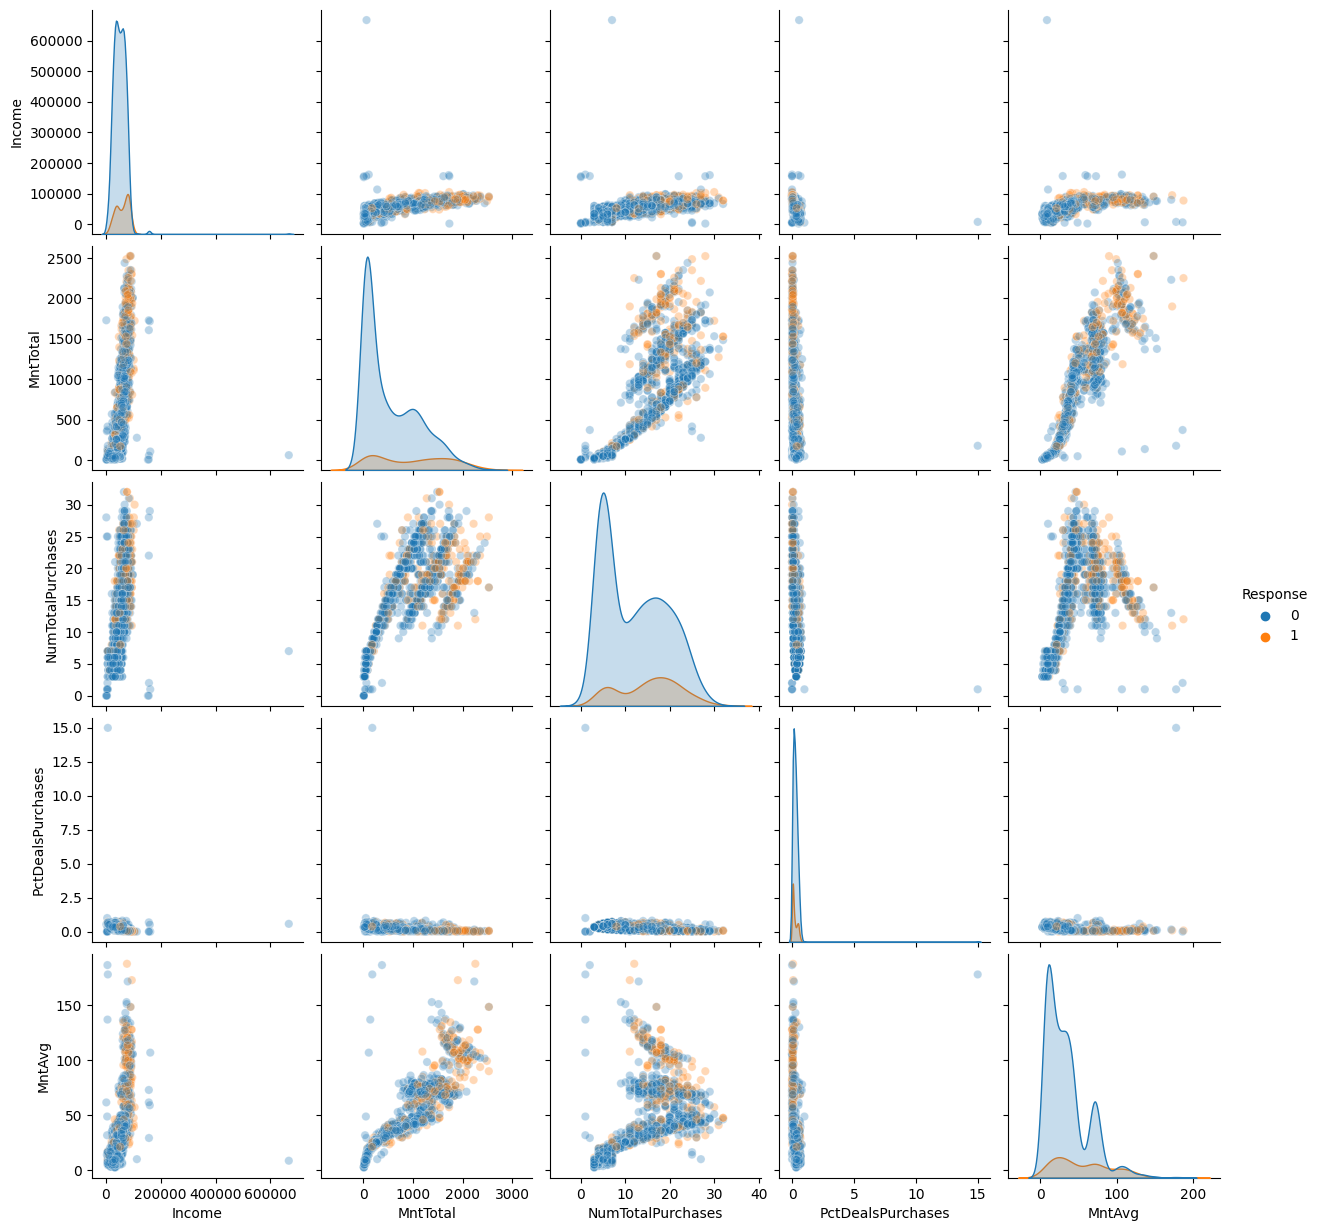

In [105]:
to_plot = ['Education', 'Income', 'MntTotal', 'NumTotalPurchases', 'PctDealsPurchases', 'Response', 'MntAvg']
sns.pairplot(df[to_plot], hue='Response',plot_kws={'alpha':0.3})

We will remove outliers:

* Age > 100
* PctDealsPurchases > 10.0
* Income > 200,000

In [106]:
df = df[df['Age'] <= 100]
df = df[df['PctDealsPurchases'] <= 10]
df = df[df['Income'] <= 200000]

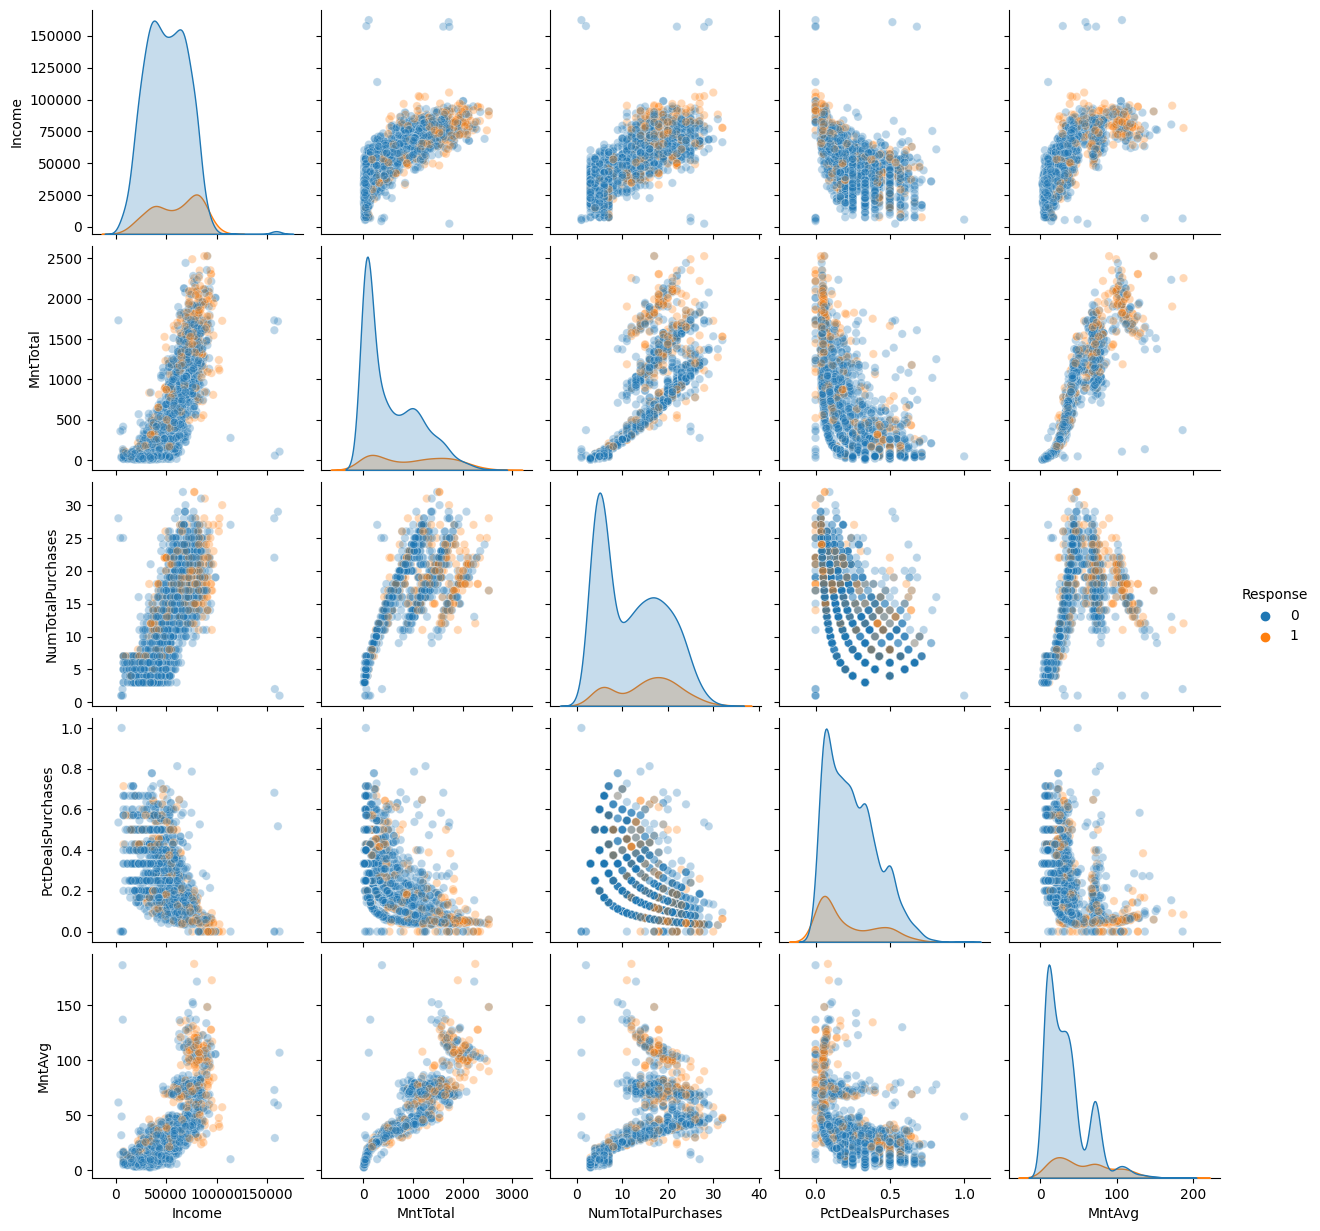

In [107]:
sns.pairplot(df[to_plot], hue='Response',plot_kws={'alpha':0.3})

It seems that there is positive correlation between total amount spent and income, as well as between number of purchases and income which is to be expected

There is also negative correlation between income and proportion of purchases with deals (that is as income increases, customers are less likely to purchase with deals) which is also expected

The relationship between total number of purchases and percentage of purchases purchased using deals is also interesting

<AxesSubplot: xlabel='Income', ylabel='Count'>

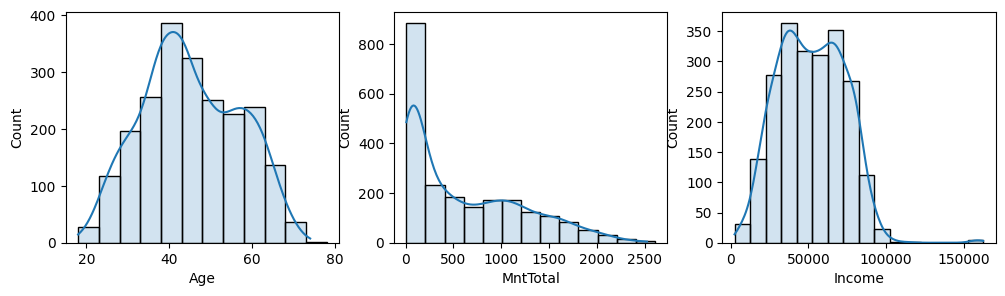

In [108]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,3))
sns.histplot(df, x='Age',kde=True, binwidth=5, alpha=0.2, ax=ax[0])
sns.histplot(df['MntTotal'], kde=True, binwidth=200, alpha=0.2, ax=ax[1])
sns.histplot(df['Income'], kde=True, binwidth=10000, alpha=0.2, ax=ax[2])

In [109]:
print('Percentage of customers with age 30-50:', ((df['Age'] <= 50).sum() - (df['Age'] <= 30).sum())/df.shape[0]*100)

Percentage of customers with age 30-50: 55.338482507950935


We can see that the majority of customers are around the age of 30-50, with most customers in their 40s

Furthermore, most customers spend $0-$200 in total

### Categorical Variables

<AxesSubplot: xlabel='Education', ylabel='Income'>

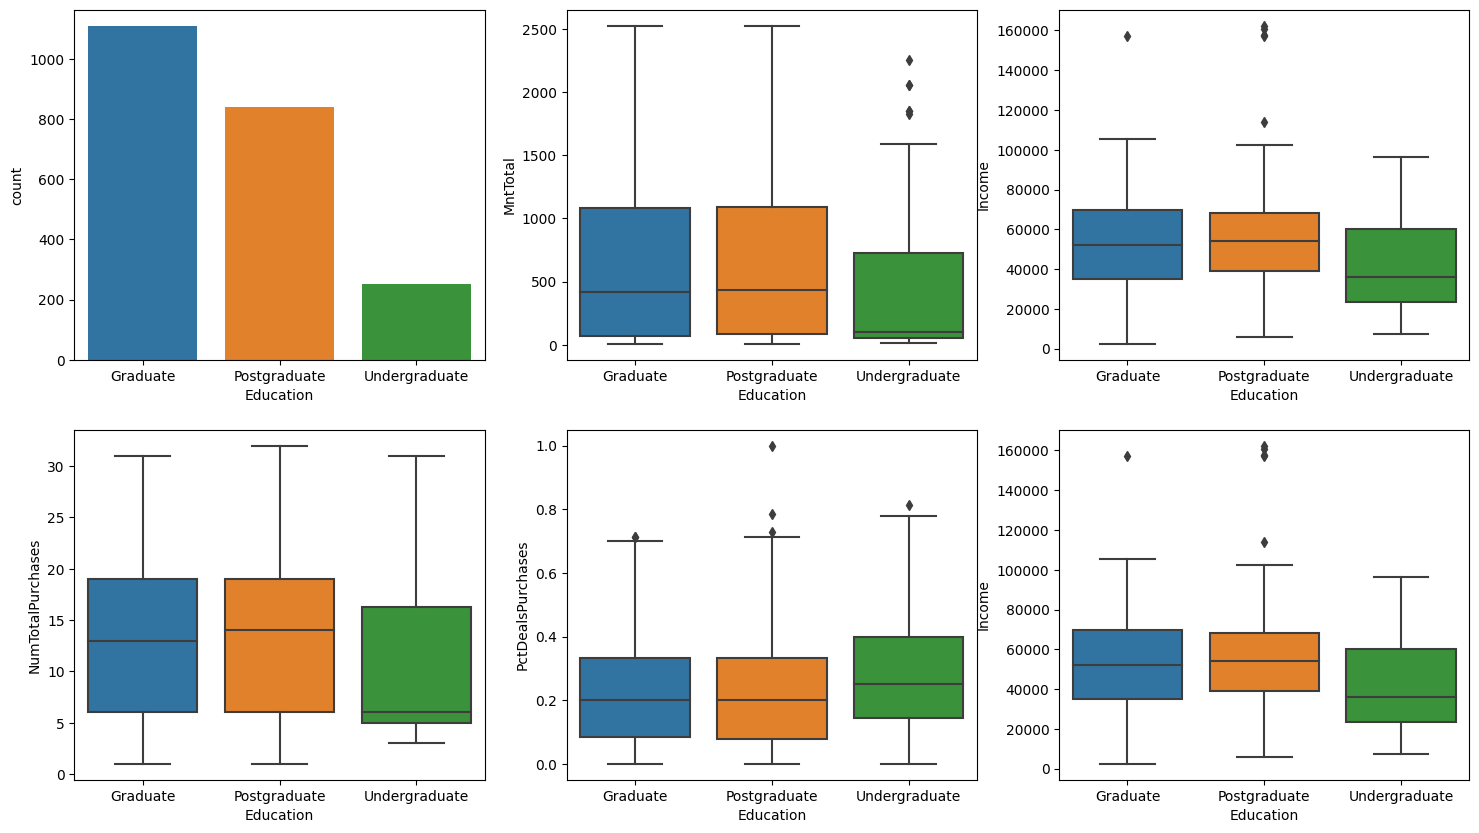

In [110]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(18,10))
sns.countplot(x=df["Education"], ax=ax[0][0])
sns.boxplot(df, x="Education", y="MntTotal", ax=ax[0][1])
sns.boxplot(df, x="Education", y="Income", ax=ax[0][2])
sns.boxplot(df, x="Education", y="NumTotalPurchases", ax=ax[1][0])
sns.boxplot(df, x="Education", y="PctDealsPurchases", ax=ax[1][1])
sns.boxplot(df, x="Education", y="Income", ax=ax[1][2])

In [111]:
df.drop(['Education'], axis=1)
df['Education_Ordinal'] = df['Education'].replace({'Undergraduate': 1, 'Graduate':2, 'Postgraduate':3})

In [112]:
df["Age"].describe()

count    2201.000000
mean       45.097683
std        11.696892
min        18.000000
25%        37.000000
50%        44.000000
75%        55.000000
max        74.000000
Name: Age, dtype: float64

In [113]:
age_groups = [x for x in range(15,76,5)] # making the groups 10 years range
df["AgeGroup"] = pd.cut(df["Age"], bins = age_groups, precision = 0, include_lowest=False)

<AxesSubplot: xlabel='NumTotalPurchases', ylabel='AgeGroup'>

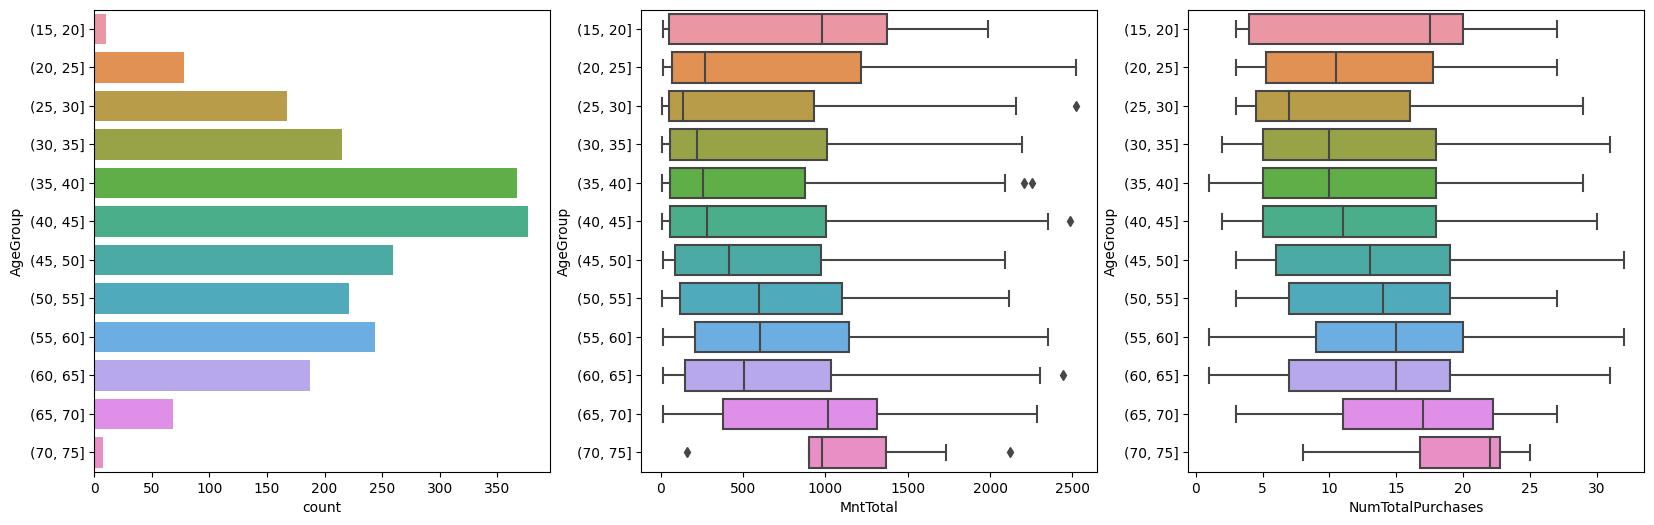

In [114]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,6))
sns.countplot(df, y="AgeGroup", ax=ax[0])
sns.boxplot(df, y="AgeGroup", x="MntTotal", ax=ax[1])
sns.boxplot(df, y="AgeGroup", x="NumTotalPurchases", ax=ax[2])
#sns.scatterplot(data=df.groupby(["AgeGroup"], as_index=False).median(), y="AgeGroup",x="MntTotal")

## Correlation Matrix

C:\Users\Claudeon\AppData\Local\Temp\ipykernel_108684\3245446333.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(),annot=True, annot_kws={'size':7}, center=0)


Text(0.5, 1.0, 'Correlation between Variables')

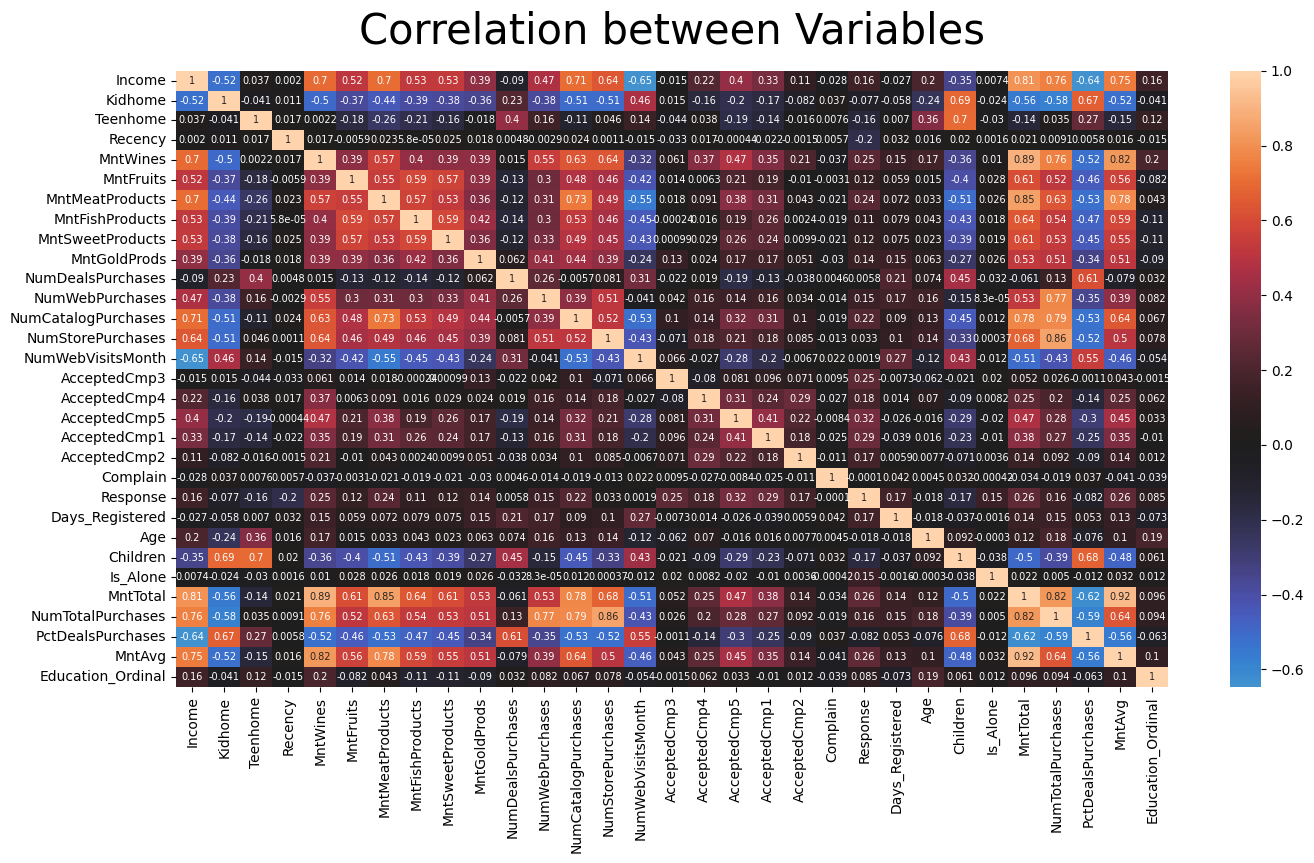

In [115]:
plt.figure(figsize=(16,8))
sns.heatmap(df.corr(),annot=True, annot_kws={'size':7}, center=0)
plt.title('Correlation between Variables', size=30, pad=20)

## Principal Component Analysis

In [116]:
df.columns

Index(['Education', 'Income', 'Kidhome', 'Teenhome', 'Recency', 'MntWines',
       'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Response', 'Days_Registered', 'Age',
       'Children', 'Is_Alone', 'MntTotal', 'NumTotalPurchases',
       'PctDealsPurchases', 'MntAvg', 'Education_Ordinal', 'AgeGroup'],
      dtype='object')

In [117]:
from sklearn.decomposition import PCA

from sklearn.preprocessing import StandardScaler

standard_scaler = StandardScaler()
scaled_df = df.drop(["Education", "AgeGroup"], axis=1)
scaled_df = pd.DataFrame(standard_scaler.fit_transform(scaled_df), columns = scaled_df.columns)

n_components=10
pca = PCA(n_components=n_components)
pca_df = pca.fit_transform(scaled_df)

Text(0.5, 1.0, 'PCA Explained Variance Ratio')

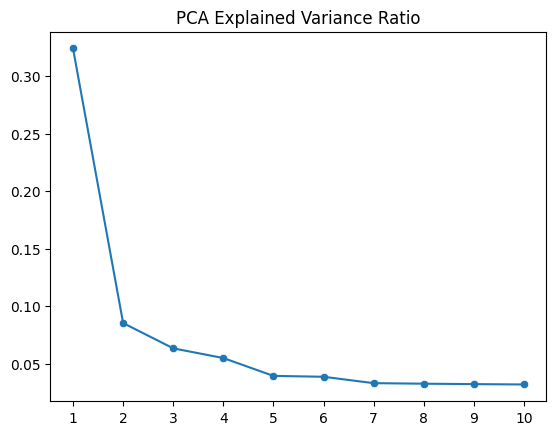

In [118]:
explained_variance_ratio = pca.explained_variance_ratio_
sns.lineplot(y=explained_variance_ratio, x=np.arange(1,n_components+1,1)).set_xticks(np.arange(1,n_components+1,1))
sns.scatterplot(y=explained_variance_ratio, x=np.arange(1,n_components+1,1))
plt.title("PCA Explained Variance Ratio")

The increase in explained variance ratio becomes smaller especially at components greater than 5. For this reason, we only consider the first 5 components of PCA.

In [119]:
explained_variance_ratio[:5].sum()

0.567660190613896

In [120]:
pca = PCA(n_components=5)
pca_df = pca.fit_transform(scaled_df)

In [121]:
pca_df = pd.DataFrame(pca_df, columns=['pca1', 'pca2', 'pca3', 'pca4', 'pca5'])
pca_df

pca1      pca2      pca3      pca4      pca5
0     4.686411  0.371285  0.160012  3.006599 -0.125288
1    -3.532015  0.139205 -0.272878 -1.426404 -1.735572
2     2.267564 -0.672311 -1.364536 -0.202256  0.892596
3    -3.110523 -1.751185  0.026078 -0.180735 -0.207782
4    -0.645787  0.266049 -0.553848  0.300835 -0.022789
...        ...       ...       ...       ...       ...
2196  2.984962  1.306216 -1.222011  1.088786  0.285659
2197 -1.767997  3.797908  1.210852 -1.324022 -2.241359
2198  2.536411 -0.789584  0.796737 -1.231869  2.644640
2199  2.116663  1.079293 -1.467864 -1.660564 -0.880593
2200 -2.337323  1.663857  1.206374 -0.090289 -1.140264

[2201 rows x 5 columns]

In [122]:
loadings = pd.DataFrame(pca.components_.T,
                        index=scaled_df.columns,
                        columns=['pca1', 'pca2', 'pca3', 'pca4', 'pca5'])
loadings

pca1      pca2      pca3      pca4      pca5
Income               0.269349  0.080314 -0.040785 -0.158049 -0.128740
Kidhome             -0.215183  0.029803  0.123089  0.166304 -0.190654
Teenhome            -0.057406  0.459675 -0.122023 -0.215043 -0.130681
Recency              0.001519  0.020081 -0.104866 -0.036552  0.284323
MntWines             0.255515  0.171303  0.168126 -0.079299  0.088937
MntFruits            0.208759 -0.072830 -0.160102  0.181397 -0.100814
MntMeatProducts      0.256492 -0.068397 -0.007425  0.073237 -0.139086
MntFishProducts      0.217361 -0.082496 -0.158305  0.181504 -0.073855
MntSweetProducts     0.210268 -0.062386 -0.135888  0.165859 -0.056811
MntGoldProds         0.174404  0.094499 -0.064207  0.235073 -0.023478
NumDealsPurchases   -0.051802  0.468352  0.008376  0.246119 -0.045213
NumWebPurchases      0.173522  0.309638 -0.026776  0.107521  0.136143
NumCatalogPurchases  0.255620  0.044670 -0.015090  0.036179 -0.118140
NumStorePurchases    0.229423  0.167436 -0.141349 -0.035755  0.135217
NumWebVisitsMonth   -0.194798  0.177214  0.192995  0.250920  0.226005
AcceptedCmp3         0.013806 -0.016761  0.221860  0.193714 -0.387305
AcceptedCmp4         0.076899  0.105277  0.360556 -0.239149  0.350448
AcceptedCmp5         0.149239 -0.082295  0.367539 -0.105414 -0.019494
AcceptedCmp1         0.129477 -0.060490  0.318358 -0.033819 -0.095118
AcceptedCmp2         0.045252  0.023055  0.355554 -0.136244  0.232626
Complain            -0.011965  0.006144 -0.011236  0.063206  0.013818
Response             0.082355 -0.000409  0.448919  0.180822 -0.261087
Days_Registered      0.028604  0.163647  0.076548  0.403057  0.335603
Age                  0.043666  0.237727 -0.111667 -0.335158 -0.129862
Children            -0.196065  0.355476 -0.000402 -0.037014 -0.231728
Is_Alone             0.008825 -0.025108  0.058435  0.053216 -0.170403
MntTotal             0.301396  0.062039  0.051752  0.042681 -0.021197
NumTotalPurchases    0.273693  0.211686 -0.080116  0.039560  0.064765
PctDealsPurchases   -0.237043  0.208828  0.089893  0.189775 -0.129908
MntAvg               0.273585  0.021628  0.087751  0.030080 -0.040237
Education_Ordinal    0.021397  0.141236  0.084267 -0.346858 -0.241919

<AxesSubplot: >

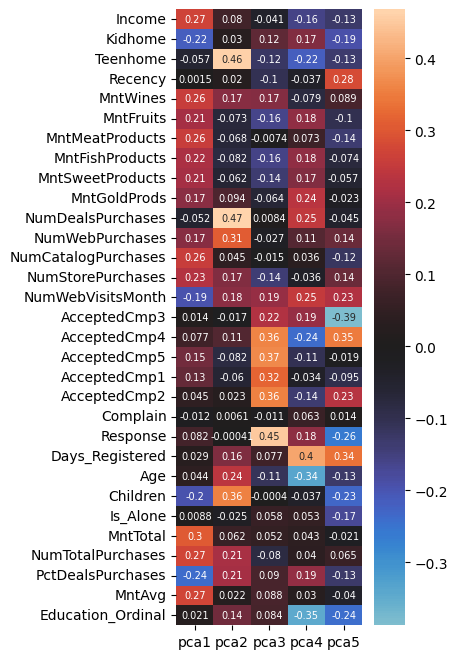

In [123]:
plt.figure(figsize=(3,8))
sns.heatmap(loadings, annot=True, annot_kws={'size':7}, center=0)

Text(0.5, 1.0, 'Principal Component Analysis')

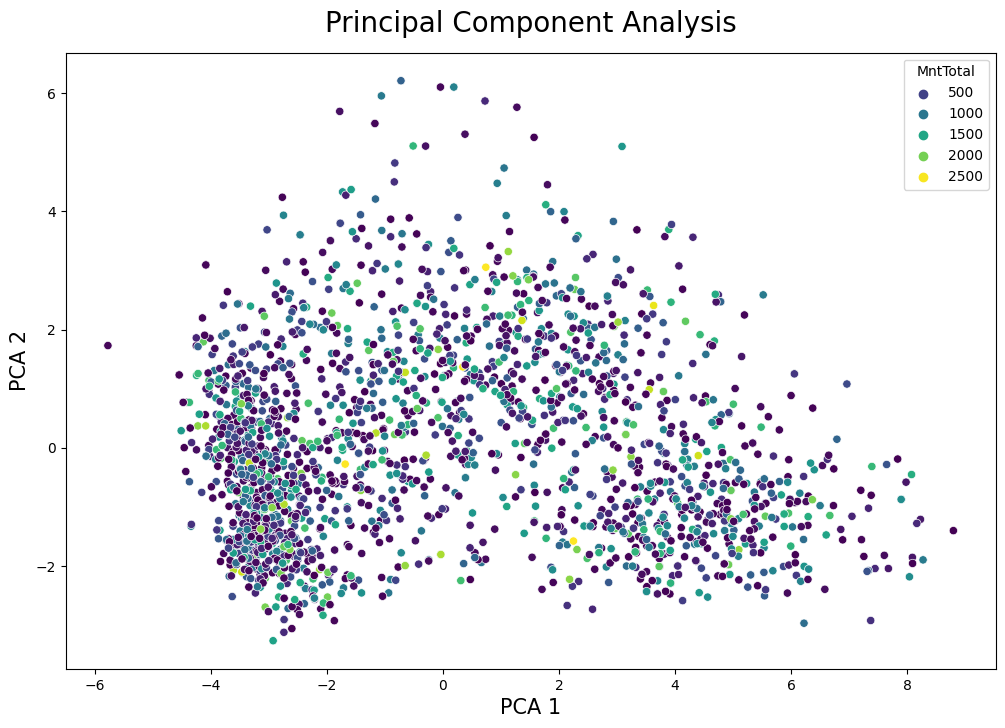

In [124]:
plt.figure(figsize=(12,8))
sns.scatterplot(x=pca_df['pca1'], y=pca_df['pca2'], 
                hue = df['MntTotal'],
                palette='viridis'
                )
# plt.xlim(0,200000)
# plt.ylim(0,80)
plt.xlabel('PCA 1',size=15)
plt.ylabel('PCA 2', size=15)
plt.title('Principal Component Analysis',size=20,pad=15)

## K Means Clustering

In [125]:
from sklearn.cluster import KMeans

def calculate_WSS(points, kmax):
  sse = []
  for k in range(1, kmax+1):
    kmeans = KMeans(n_clusters = k).fit(points)
    sse.append(kmeans.inertia_)
  return sse

In [126]:
wss = calculate_WSS(pca_df, 15)

c:\Users\Claudeon\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Claudeon\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Claudeon\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Claudeon\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Se

Text(0, 0.5, 'Sum of Squared Distances to Centroids')

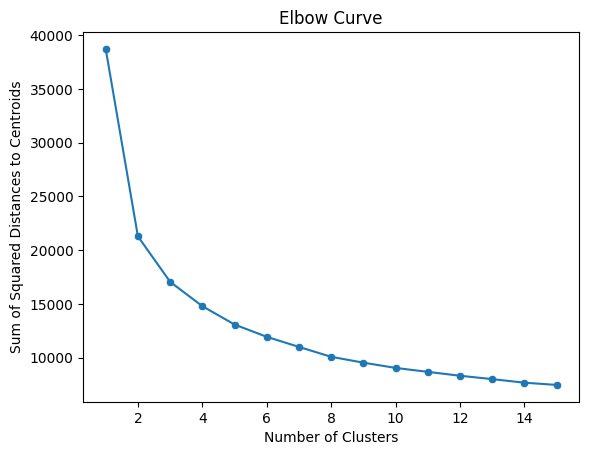

In [127]:
sns.lineplot(y=wss, x=np.arange(1,16,1))
sns.scatterplot(y=wss, x=np.arange(1,16,1))
plt.title("Elbow Curve")
plt.xlabel("Number of Clusters")
plt.ylabel("Sum of Squared Distances to Centroids")

### Cluster Analysis (k=5)

In [128]:
kmeans = KMeans(n_clusters=5, random_state=420)
                  
clusters = kmeans.fit_predict(pca_df)

c:\Users\Claudeon\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [129]:
clusters

array([2, 3, 2, ..., 2, 4, 3])

In [130]:
pca_df['cluster'] = clusters
pca_df

pca1      pca2      pca3      pca4      pca5  cluster
0     4.686411  0.371285  0.160012  3.006599 -0.125288        2
1    -3.532015  0.139205 -0.272878 -1.426404 -1.735572        3
2     2.267564 -0.672311 -1.364536 -0.202256  0.892596        2
3    -3.110523 -1.751185  0.026078 -0.180735 -0.207782        1
4    -0.645787  0.266049 -0.553848  0.300835 -0.022789        4
...        ...       ...       ...       ...       ...      ...
2196  2.984962  1.306216 -1.222011  1.088786  0.285659        4
2197 -1.767997  3.797908  1.210852 -1.324022 -2.241359        3
2198  2.536411 -0.789584  0.796737 -1.231869  2.644640        2
2199  2.116663  1.079293 -1.467864 -1.660564 -0.880593        4
2200 -2.337323  1.663857  1.206374 -0.090289 -1.140264        3

[2201 rows x 6 columns]

C:\Users\Claudeon\AppData\Local\Temp\ipykernel_108684\3137867645.py:2: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  sns.scatterplot(pca_df, x='pca1', y='pca2', hue=pca_df['cluster'], palette=sns.color_palette("tab10"), ax=ax[0][0])
C:\Users\Claudeon\AppData\Local\Temp\ipykernel_108684\3137867645.py:3: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  sns.scatterplot(pca_df, x='pca1', y='pca3', hue=pca_df['cluster'], palette=sns.color_palette("tab10"), ax=ax[0][1])
C:\Users\Claudeon\AppData\Local\Temp\ipykernel_108684\3137867645.py:4: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  sns.scatterplot(pca_df, x='pca2', y='pca3', hue=pca_df['cluster'], palette=sns.color_palette("tab10"), ax=ax[1][0])
C:\Users\Claudeon\AppData\Local\Temp\ipykernel_108684\3137867645.py:5: UserWarning: The palette list has more values (10) than needed (5), which may

<AxesSubplot: xlabel='pca1', ylabel='pca4'>

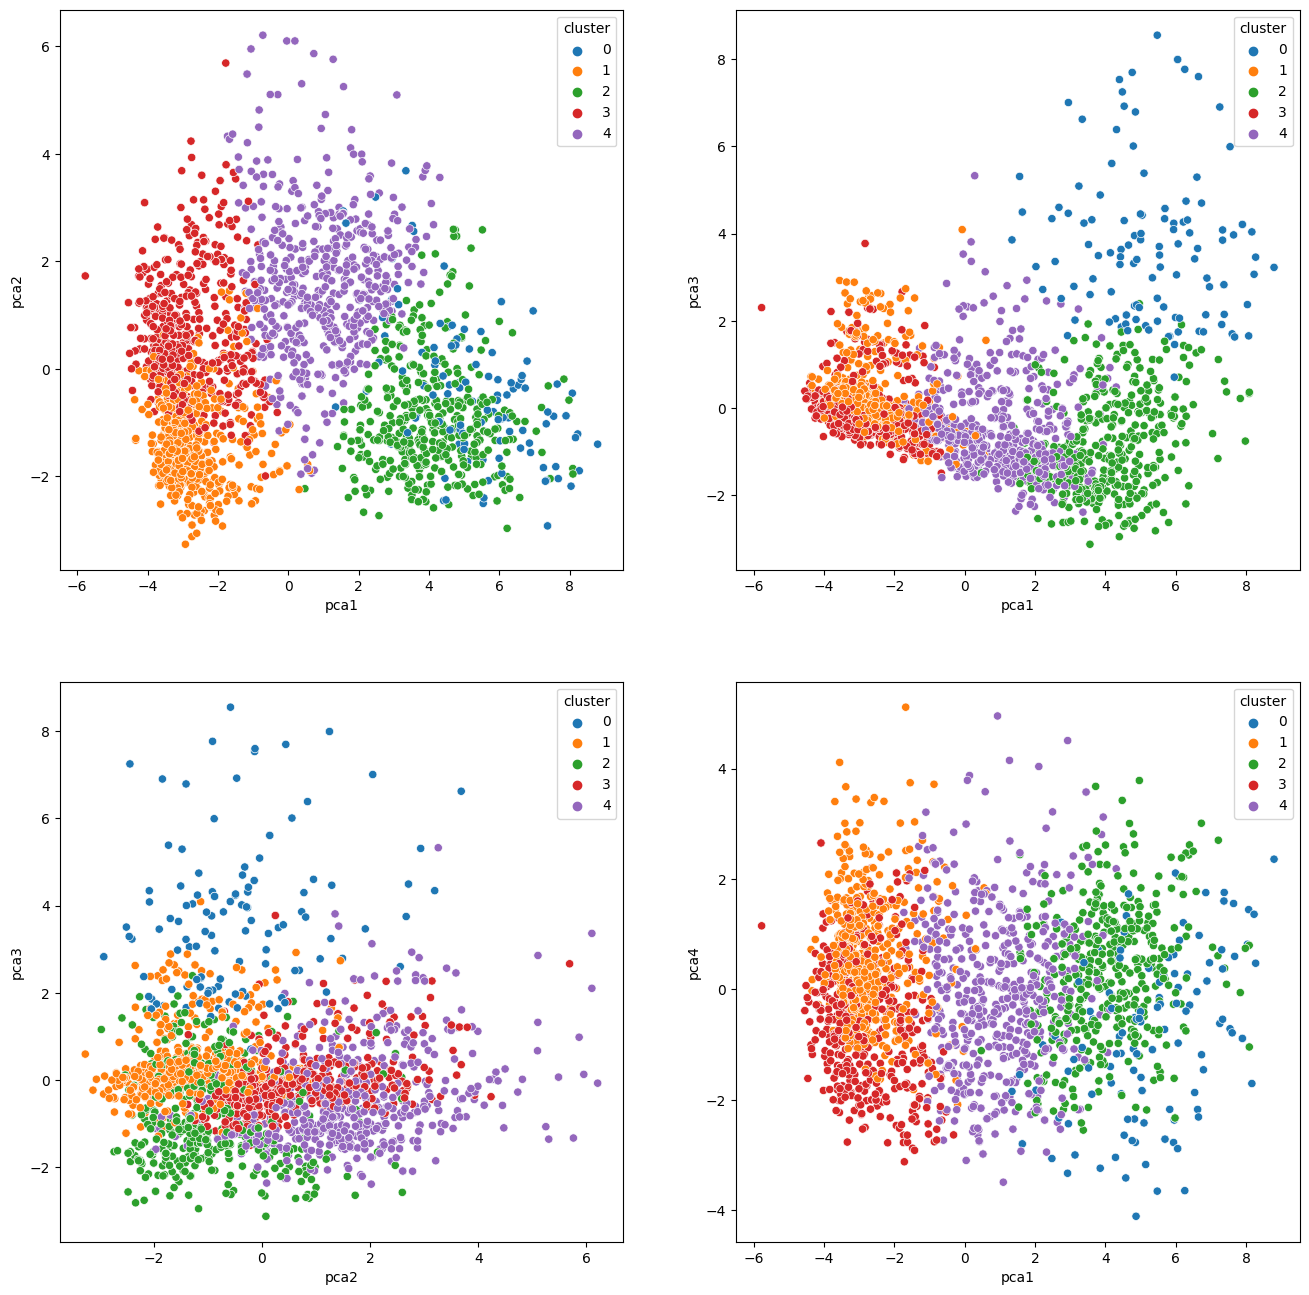

In [131]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16,16))
sns.scatterplot(pca_df, x='pca1', y='pca2', hue=pca_df['cluster'], palette=sns.color_palette("tab10"), ax=ax[0][0])
sns.scatterplot(pca_df, x='pca1', y='pca3', hue=pca_df['cluster'], palette=sns.color_palette("tab10"), ax=ax[0][1])
sns.scatterplot(pca_df, x='pca2', y='pca3', hue=pca_df['cluster'], palette=sns.color_palette("tab10"), ax=ax[1][0])
sns.scatterplot(pca_df, x='pca1', y='pca4', hue=pca_df['cluster'], palette=sns.color_palette("tab10"), ax=ax[1][1])

In [132]:
df['cluster'] = clusters
df['cluster'] = df['cluster'].astype('category')

<AxesSubplot: xlabel='cluster', ylabel='PctDealsPurchases'>

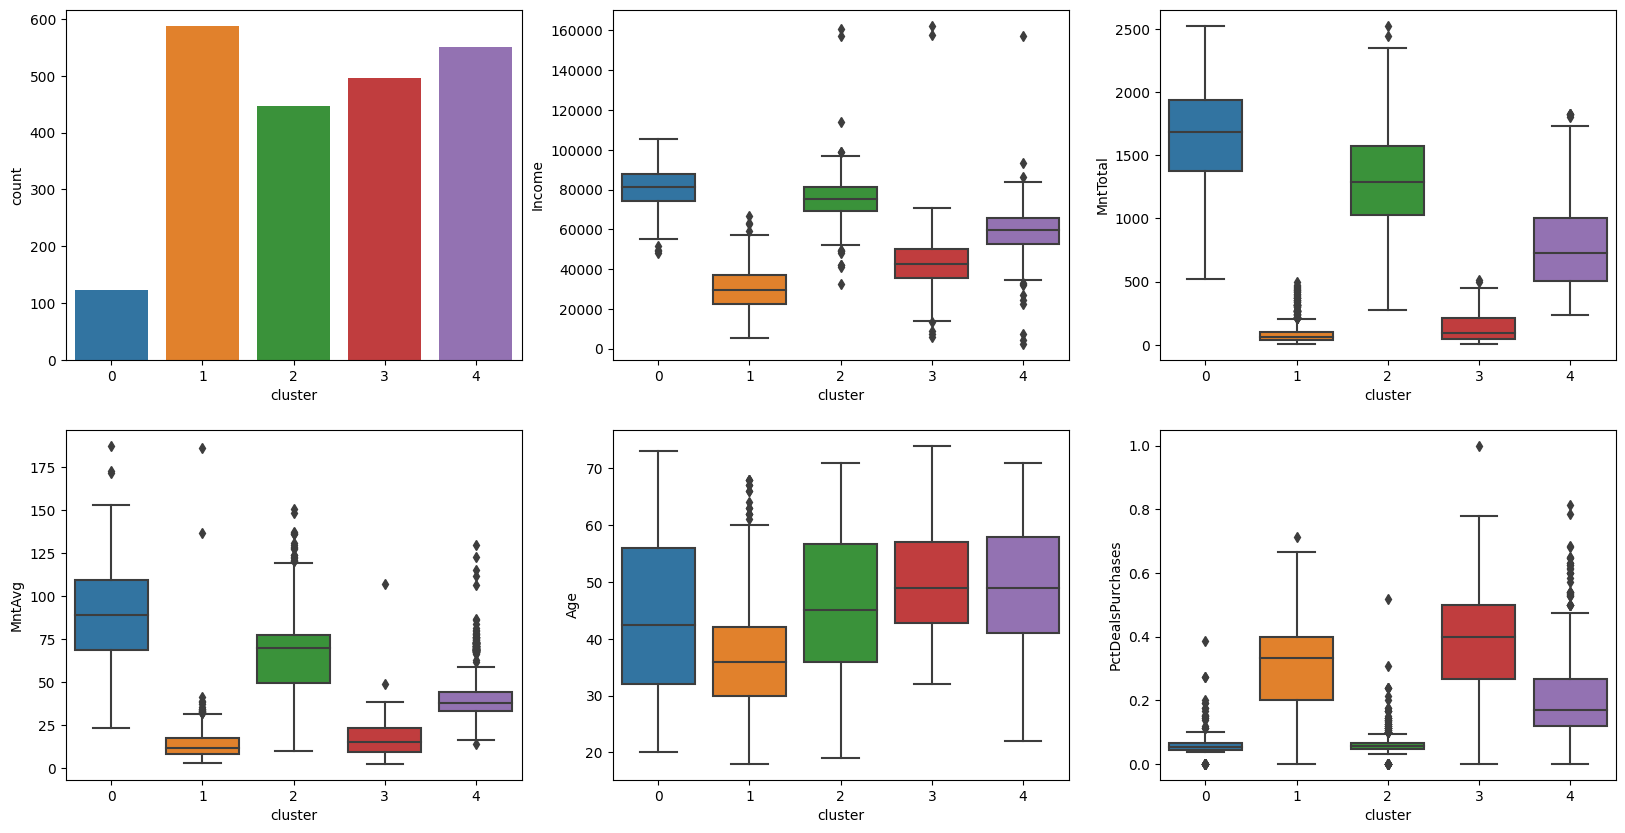

In [133]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20,10))
sns.countplot(df, x='cluster', ax=ax[0][0])
sns.boxplot(df, y='Income', x='cluster', ax=ax[0][1])
sns.boxplot(df, y='MntTotal', x='cluster', ax=ax[0][2])
sns.boxplot(df, y='MntAvg', x='cluster', ax=ax[1][0])
sns.boxplot(df, y='Age', x='cluster', ax=ax[1][1])
sns.boxplot(df, y='PctDealsPurchases', x='cluster', ax=ax[1][2])

### Cluster Analysis (k=4)

In [134]:
kmeans = KMeans(n_clusters=4, random_state=420)
                  
clusters = kmeans.fit_predict(pca_df.drop('cluster', axis=1))

c:\Users\Claudeon\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


C:\Users\Claudeon\AppData\Local\Temp\ipykernel_108684\529227270.py:5: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.scatterplot(pca_df, x='pca1', y='pca2', hue=pca_df['cluster'], palette=sns.color_palette("tab10"), ax=ax[0][0])
C:\Users\Claudeon\AppData\Local\Temp\ipykernel_108684\529227270.py:6: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.scatterplot(pca_df, x='pca1', y='pca3', hue=pca_df['cluster'], palette=sns.color_palette("tab10"), ax=ax[0][1])
C:\Users\Claudeon\AppData\Local\Temp\ipykernel_108684\529227270.py:7: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.scatterplot(pca_df, x='pca2', y='pca3', hue=pca_df['cluster'], palette=sns.color_palette("tab10"), ax=ax[1][0])
C:\Users\Claudeon\AppData\Local\Temp\ipykernel_108684\529227270.py:8: UserWarning: The palette list has more values (10) than needed (4), which may not

<AxesSubplot: xlabel='pca1', ylabel='pca4'>

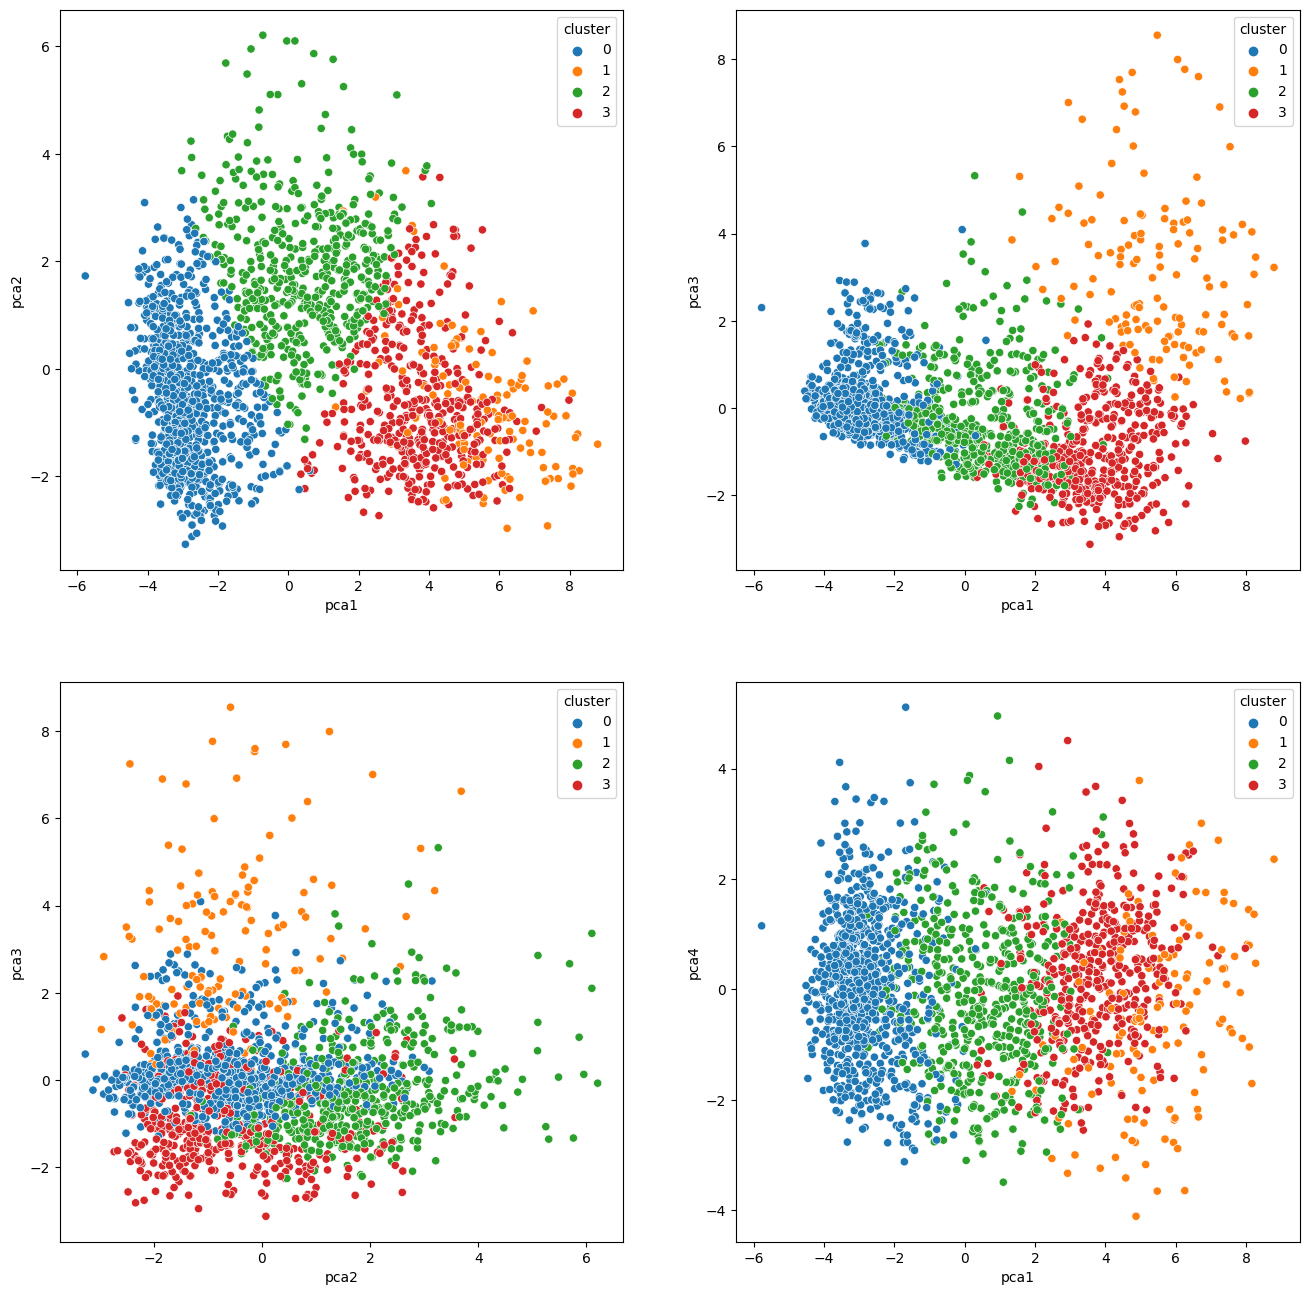

In [135]:
pca_df['cluster'] = clusters
pca_df

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16,16))
sns.scatterplot(pca_df, x='pca1', y='pca2', hue=pca_df['cluster'], palette=sns.color_palette("tab10"), ax=ax[0][0])
sns.scatterplot(pca_df, x='pca1', y='pca3', hue=pca_df['cluster'], palette=sns.color_palette("tab10"), ax=ax[0][1])
sns.scatterplot(pca_df, x='pca2', y='pca3', hue=pca_df['cluster'], palette=sns.color_palette("tab10"), ax=ax[1][0])
sns.scatterplot(pca_df, x='pca1', y='pca4', hue=pca_df['cluster'], palette=sns.color_palette("tab10"), ax=ax[1][1])

In [136]:
df['cluster'] = clusters
df['cluster'] = df['cluster'].astype('category')
df.to_csv('data/clean_marketing_campaign.csv')

In [137]:
df

Education   Income  Kidhome  Teenhome  Recency  MntWines  MntFruits  \
0         Graduate  58138.0        0         0       58       635         88   
1         Graduate  46344.0        1         1       38        11          1   
2         Graduate  71613.0        0         0       26       426         49   
3         Graduate  26646.0        1         0       26        11          4   
4     Postgraduate  58293.0        1         0       94       173         43   
...            ...      ...      ...       ...      ...       ...        ...   
2235      Graduate  61223.0        0         1       46       709         43   
2236  Postgraduate  64014.0        2         1       56       406          0   
2237      Graduate  56981.0        0         0       91       908         48   
2238  Postgraduate  69245.0        0         1        8       428         30   
2239  Postgraduate  52869.0        1         1       40        84          3   

      MntMeatProducts  MntFishProducts  MntSweetProducts  ...  Age  Children  \
0                 546              172                88  ...   57         0   
1                   6                2                 1  ...   60         2   
2                 127              111                21  ...   49         0   
3                  20               10                 3  ...   30         1   
4                 118               46                27  ...   33         1   
...               ...              ...               ...  ...  ...       ...   
2235              182               42               118  ...   47         1   
2236               30                0                 0  ...   68         3   
2237              217               32                12  ...   33         0   
2238              214               80                30  ...   58         1   
2239               61                2                 1  ...   60         2   

      Is_Alone  MntTotal  NumTotalPurchases  PctDealsPurchases     MntAvg  \
0            1      1617                 22           0.136364  73.500000   
1            1        27                  4           0.500000   6.750000   
2            0       776                 20           0.050000  38.800000   
3            0        53                  6           0.333333   8.833333   
4            0       422                 14           0.357143  30.142857   
...        ...       ...                ...                ...        ...   
2235         0      1341                 16           0.125000  83.812500   
2236         0       444                 15           0.466667  29.600000   
2237         1      1241                 18           0.055556  68.944444   
2238         0       843                 21           0.095238  40.142857   
2239         0       172                  8           0.375000  21.500000   

      Education_Ordinal  AgeGroup  cluster  
0                     2  (55, 60]        3  
1                     2  (55, 60]        0  
2                     2  (45, 50]        3  
3                     2  (25, 30]        0  
4                     3  (30, 35]        2  
...                 ...       ...      ...  
2235                  2  (45, 50]        3  
2236                  3  (65, 70]        2  
2237                  2  (30, 35]        3  
2238                  3  (55, 60]        2  
2239                  3  (55, 60]        0  

[2201 rows x 34 columns]

<AxesSubplot: xlabel='cluster', ylabel='PctDealsPurchases'>

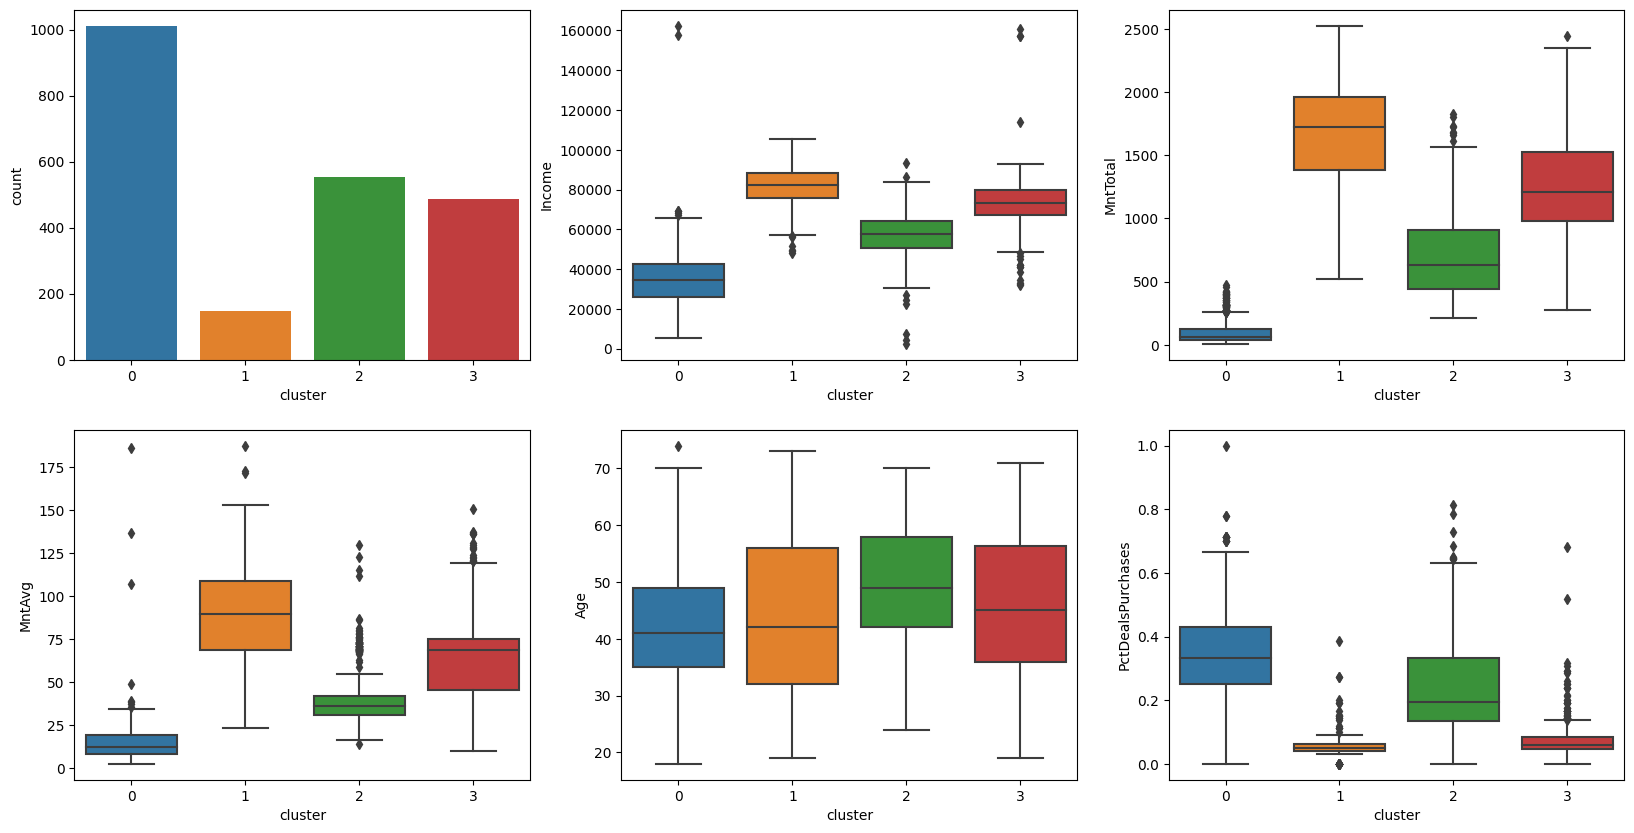

In [138]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20,10))
sns.countplot(df, x='cluster', ax=ax[0][0])
sns.boxplot(df, y='Income', x='cluster', ax=ax[0][1])
sns.boxplot(df, y='MntTotal', x='cluster', ax=ax[0][2])
sns.boxplot(df, y='MntAvg', x='cluster', ax=ax[1][0])
sns.boxplot(df, y='Age', x='cluster', ax=ax[1][1])
sns.boxplot(df, y='PctDealsPurchases', x='cluster', ax=ax[1][2])

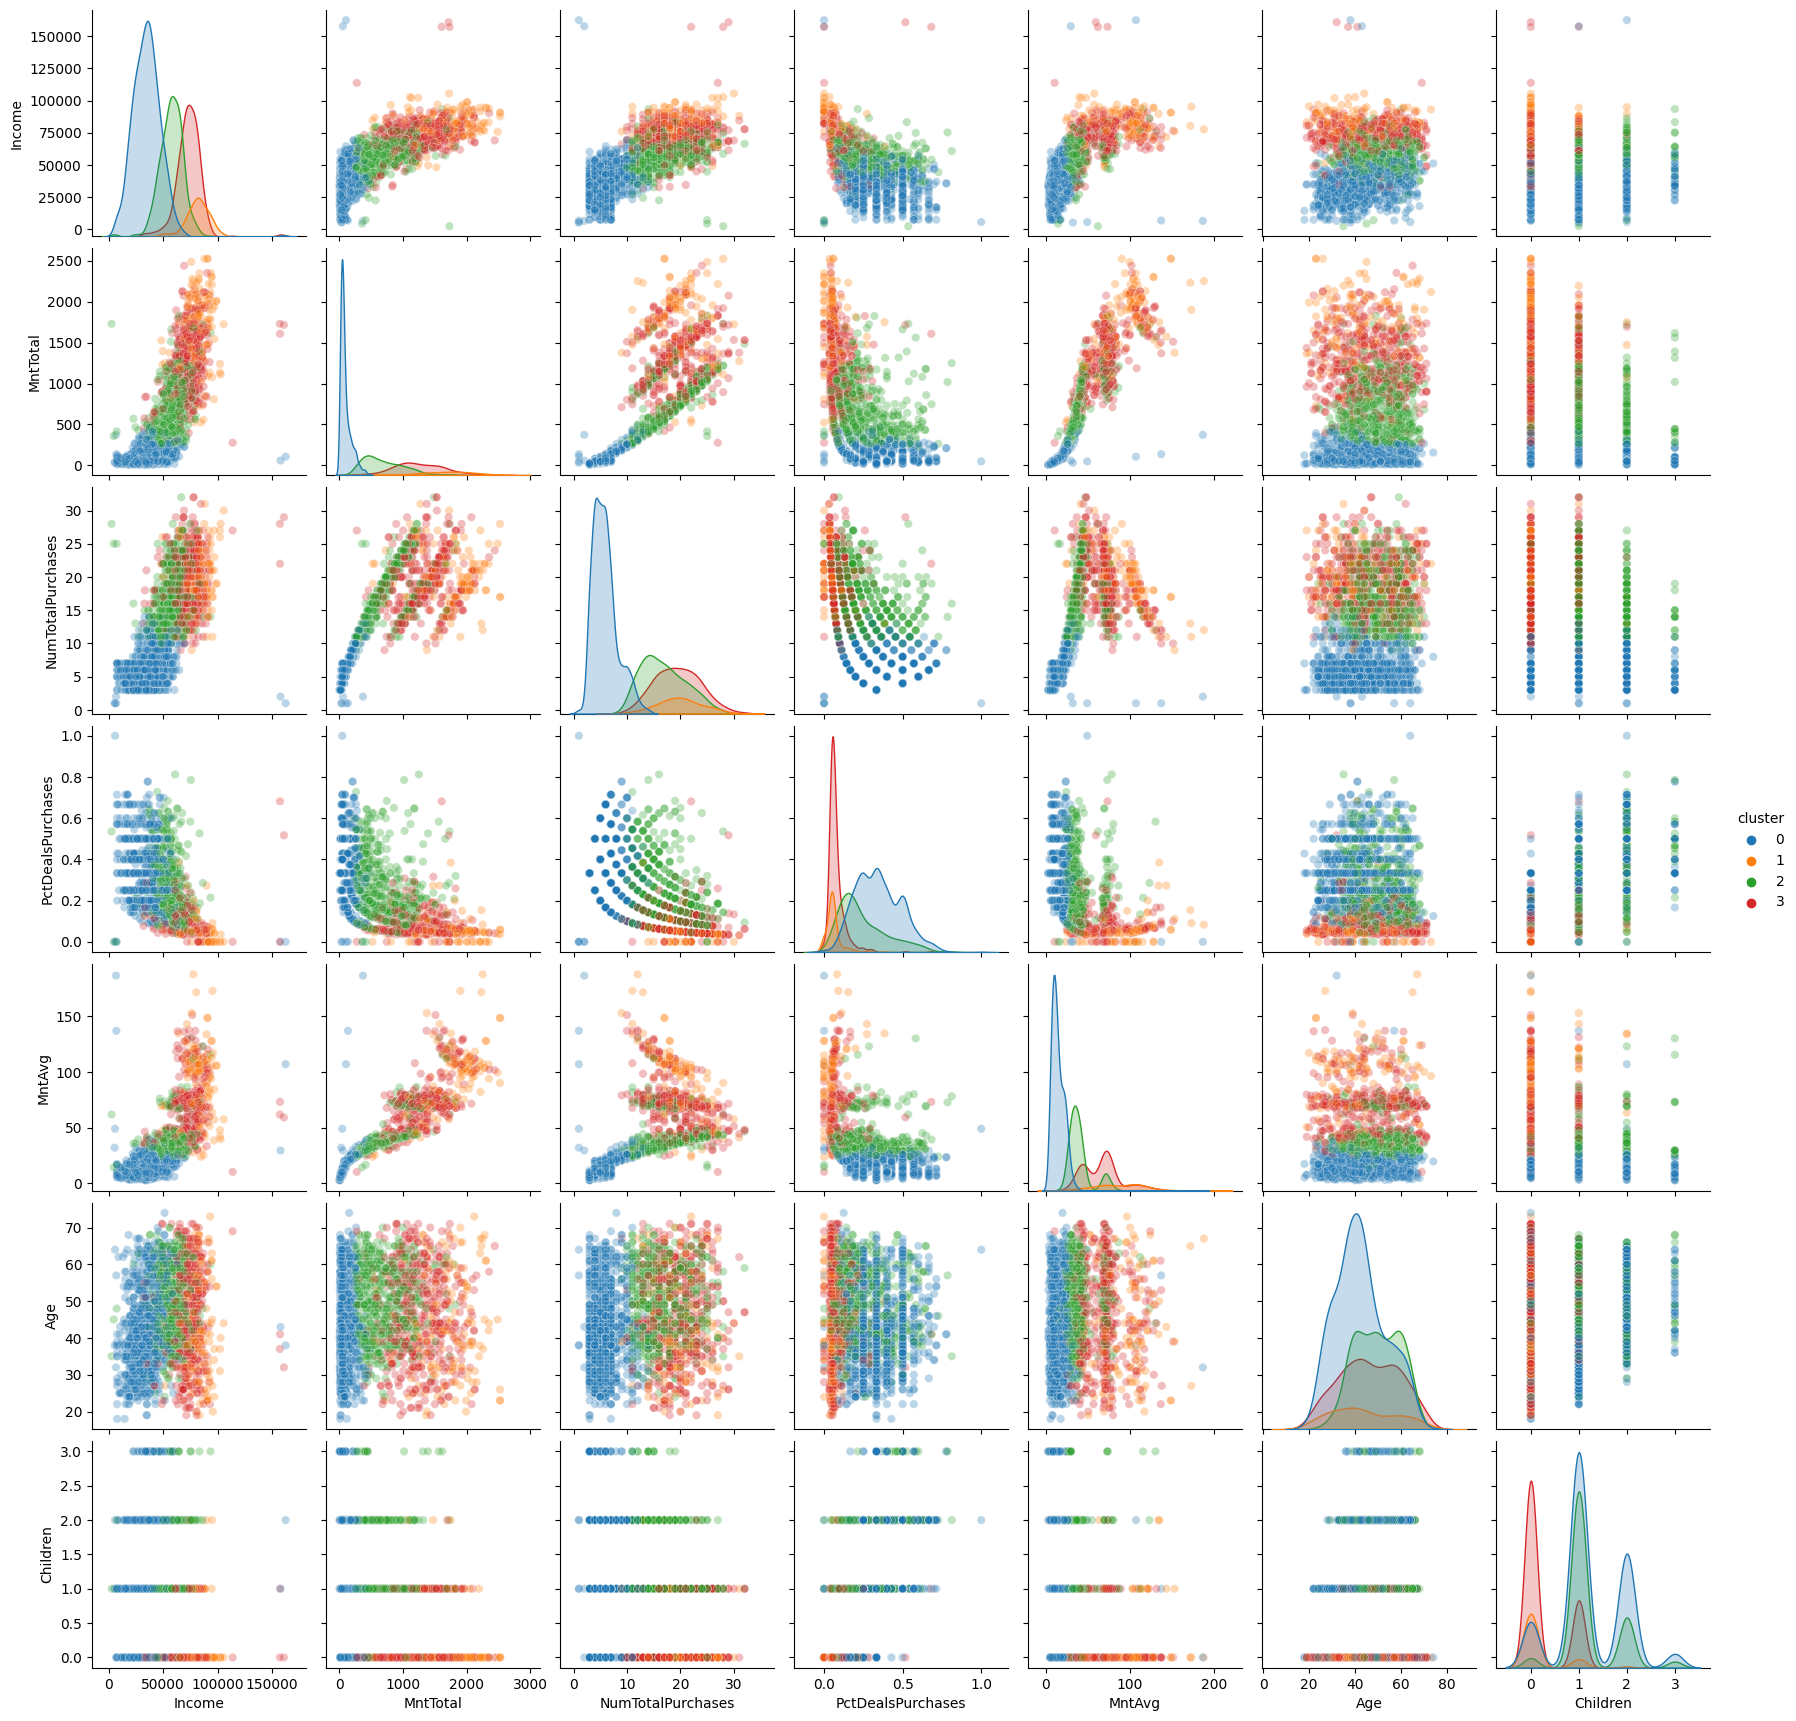

In [144]:
to_plot = ['Education', 'Income', 'MntTotal', 'NumTotalPurchases', 'PctDealsPurchases', 'MntAvg', 'cluster', 'Age']
sns.pairplot(df[to_plot], hue='cluster',plot_kws={'alpha':0.3})

We can identify 4 clusters of customers:
1. Cluster 0 (blue): consists mostly of low income customers which is the majority. Customers in this group often make purchases with discounts (on average 35% of a customer's purchase is made with discount).
2. Cluster 1 (orange): high income customers with large spread in income, with the highest average amount spent per purchase. Customers in this group do not usually make purchases with discounts.
3. Cluster 2 (green): lower-middle income customers. Customers in this group sometimes make purchases with discounts (on average 20% of a customer's purchase is made with discount).
3. Cluster 3 (red): higher-middle income customers

<AxesSubplot: xlabel='cluster', ylabel='Children'>

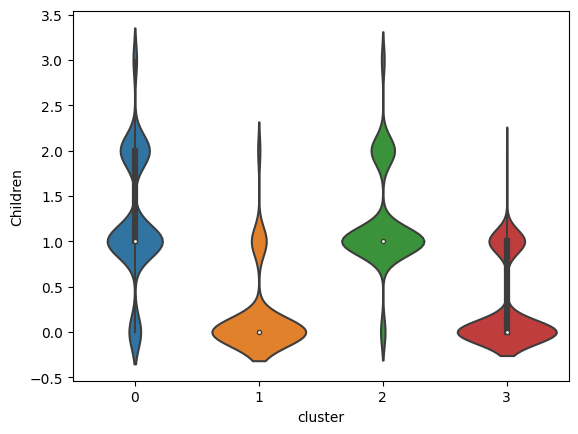

In [148]:
sns.violinplot(df, y='Children', x='cluster')

Cluster 0 and 2 customers (low and lower-middle income) tend to have between 1-2 children (mostly 2), but clusters 1 and 3 customers (high and higher-middle) tend to have no children.

<AxesSubplot: xlabel='cluster', ylabel='Education_Ordinal'>

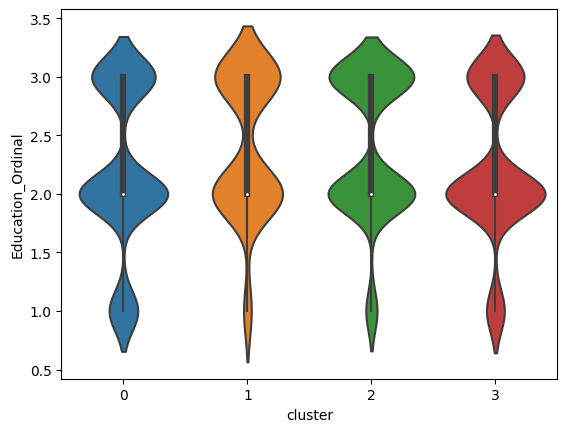

In [150]:
sns.violinplot(df, y='Education_Ordinal', x='cluster')

There does not seem to be any remarkable difference between clusters with regards to education level.

<AxesSubplot: xlabel='cluster', ylabel='MntGoldProds'>

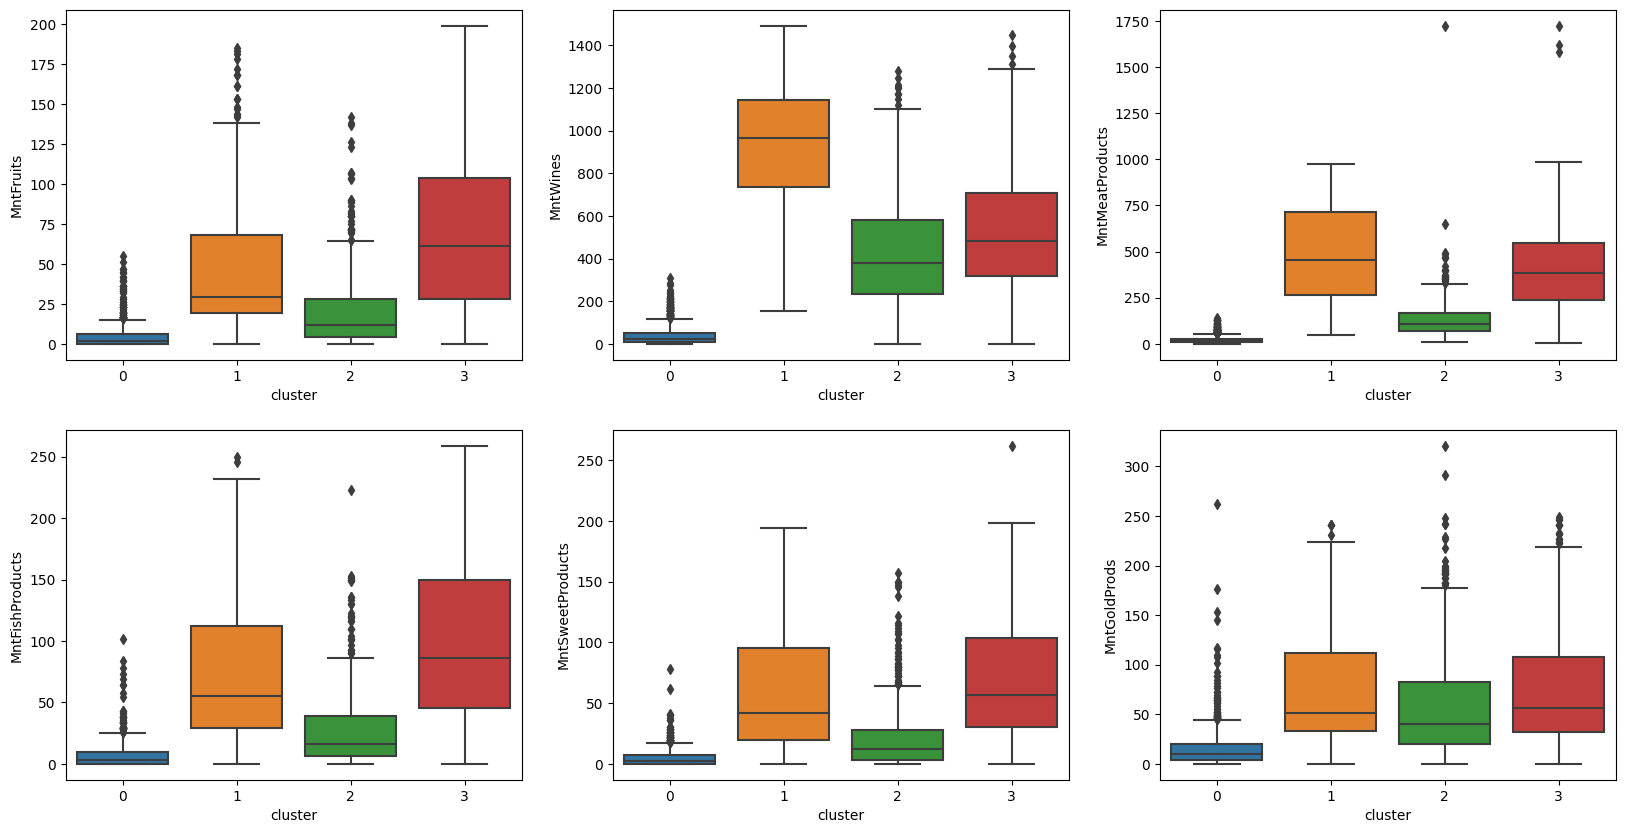

In [153]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20,10))
sns.boxplot(df, y='MntFruits', x='cluster', ax=ax[0][0])
sns.boxplot(df, y='MntWines', x='cluster', ax=ax[0][1])
sns.boxplot(df, y='MntMeatProducts', x='cluster', ax=ax[0][2])
sns.boxplot(df, y='MntFishProducts', x='cluster', ax=ax[1][0])
sns.boxplot(df, y='MntSweetProducts', x='cluster', ax=ax[1][1])
sns.boxplot(df, y='MntGoldProds', x='cluster', ax=ax[1][2])

There are a few observations we can glean from this visualization:
* Cluster 1 customers (mostly high income) are more likely to purchase wines than any other groups
* They are also the most likely to purchase Meat products
* Cluster 3 customers (mostly higher-middle income) are the most likely to produce Fruits, Fish, and Sweet products
* Cluster 0 customers (low income) spend the least on all product categories.

In [154]:
# Likelihood of a customer buying from Web, Catalog, or Store
df['PctWebPurchases'] = df['NumWebPurchases'] / df['NumTotalPurchases']
df['PctCatalogPurchases']= df['NumCatalogPurchases'] / df['NumTotalPurchases']
df['PctStorePurchases']= df['NumStorePurchases'] / df['NumTotalPurchases']

In [157]:
# Percentage of amount spent on certain products as a proportion of total amount spent on all purchases
df['PctFruits'] = df['MntFruits'] / df['MntTotal']
df['PctWines'] = df['MntWines'] / df['MntTotal']
df['PctMeatProducts'] = df['MntMeatProducts'] / df['MntTotal']
df['PctFishProducts'] = df['MntFishProducts'] / df['MntTotal']
df['PctSweetProducts'] = df['MntSweetProducts'] / df['MntTotal']
df['PctGoldProds'] = df['MntGoldProds'] / df['MntTotal']

<AxesSubplot: xlabel='cluster', ylabel='PctGoldProds'>

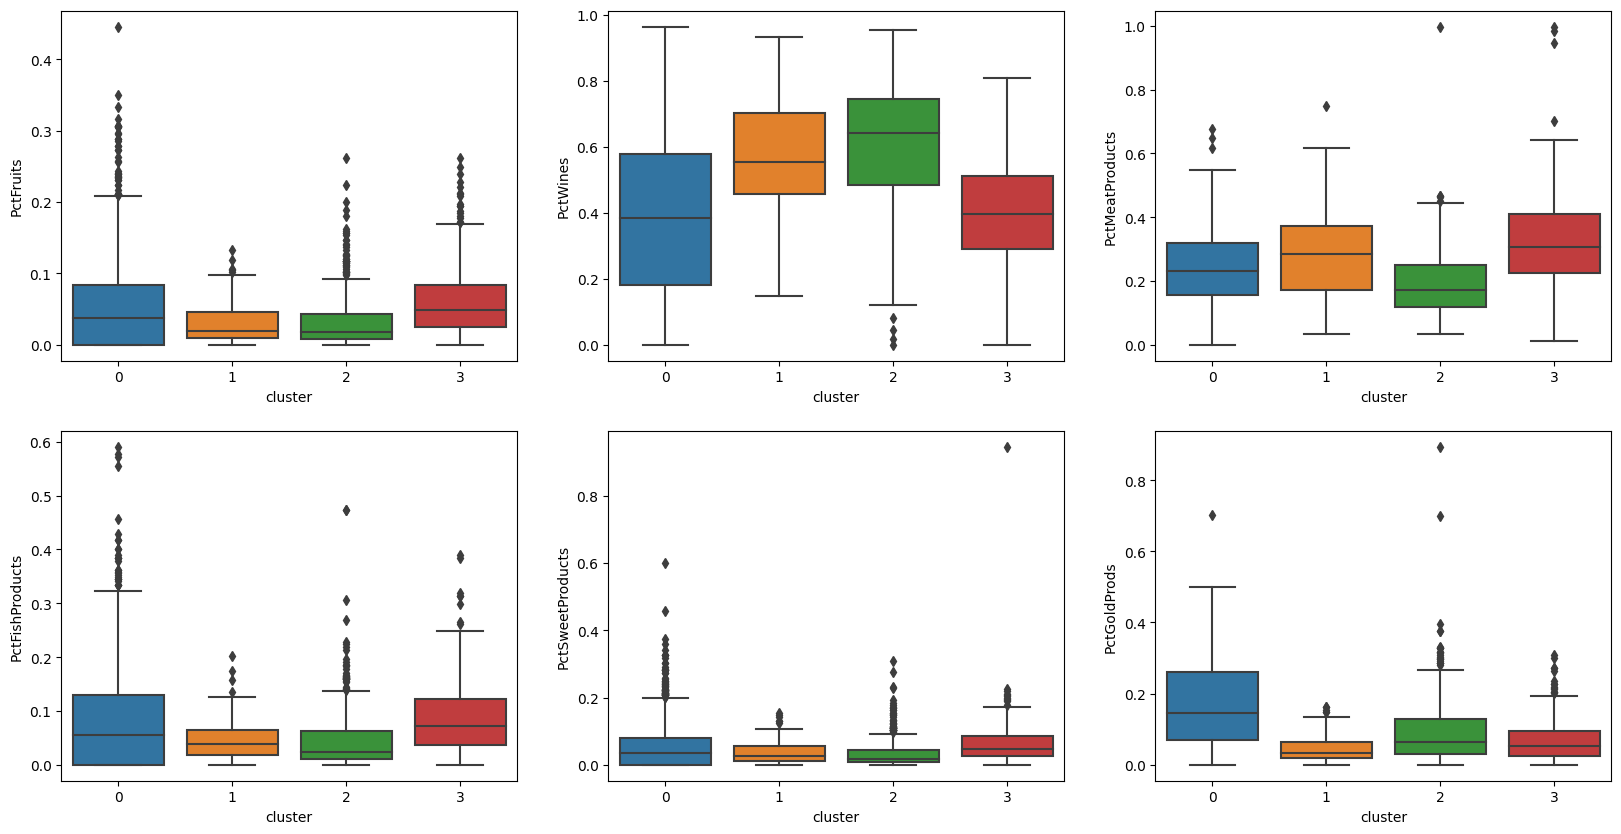

In [158]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20,10))
sns.boxplot(df, y='PctFruits', x='cluster', ax=ax[0][0])
sns.boxplot(df, y='PctWines', x='cluster', ax=ax[0][1])
sns.boxplot(df, y='PctMeatProducts', x='cluster', ax=ax[0][2])
sns.boxplot(df, y='PctFishProducts', x='cluster', ax=ax[1][0])
sns.boxplot(df, y='PctSweetProducts', x='cluster', ax=ax[1][1])
sns.boxplot(df, y='PctGoldProds', x='cluster', ax=ax[1][2])

Cluster 1 and 2 customers spend 60% of their purchases on wines on average, while cluster 0 and 3 customers spend 40% of their purchases on wines on average. Wine thus takes up a significant proportion of a customer's purchase.

<AxesSubplot: xlabel='cluster', ylabel='PctStorePurchases'>

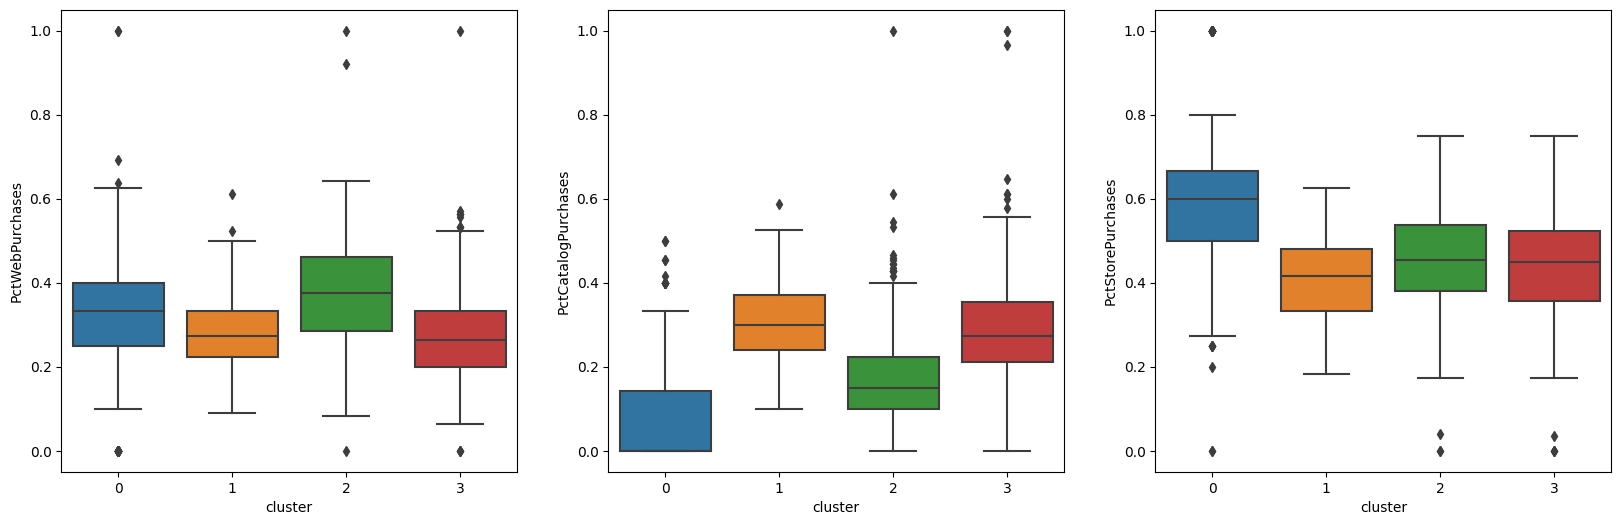

In [155]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,6))
sns.boxplot(df, y='PctWebPurchases', x='cluster', ax=ax[0])
sns.boxplot(df, y='PctCatalogPurchases', x='cluster', ax=ax[1])
sns.boxplot(df, y='PctStorePurchases', x='cluster', ax=ax[2])

There are a few observations we can glean from this visualization:
* Cluster 0 customers (mostly low income) are most likely to buy directly from stores, and they are not likely to buy from catalogues
* Customers from other clusters are also most likely to buy directly from stores, albeit less likely compared to group 0 customers.

## Conclusion

* There are 4 clusters of customers and they can be identified based on their income, amount spent on average per purchase (MntAvg), and likelihood of purchasing with discounts (PctDealsPurchases).
* Each cluster has a different spending patterns from others (which category of product take a significant proportion of their purchase), number of children.
* Customers are most likely to buy directly from stores, so more budget could be allocated towards getting more customers to buy directly from stores especially for customers in cluster 0 (low income), for example more discounts/sales could be arranged since customers from this group also tend to purchase with deals.
* Wines take up a significant proportion of spending, so to increase revenue quickly wines can be promoted through targeted marketing campaigns and advertisements